In [1]:
!pip install pyspark py4j
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Basics").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=cee73f751bc2f3e2f9927c9866e924eef914bab36528791ce5a82cfa05106100
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [37]:
# Path of the CSV File
file_path = "/content/sample_data/NEO_CLEAN_FINAL.csv"

# Read the CSV file into a DataFrame.
neo = spark.read.csv(file_path, header=True, inferSchema=True)

neo.show()

+--------+-------------------+------------------+----------------------+----------------------+-------------+-----------------+-------------+------------+
|  neo_id|               name|absolute_magnitude|estimated_diameter_min|estimated_diameter_max|orbiting_body|relative_velocity|miss_distance|is_hazardous|
+--------+-------------------+------------------+----------------------+----------------------+-------------+-----------------+-------------+------------+
| 2162117| 162117 (1998 SD15)|             19.14|           0.394961694|           0.883161196|        Earth|      71745.40105|5.814362332E7|       false|
| 2349507|   349507 (2008 QY)|              18.5|           0.530340723|           1.185877909|        Earth|      109949.7571|5.580104782E7|        true|
| 2455415|   455415 (2003 GA)|             21.45|           0.136318556|           0.304817558|        Earth|       24865.5068|6.720688772E7|       false|
| 3132126|          (2002 PB)|             20.63|           0.19886345

In [38]:
neo.count()

338199

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

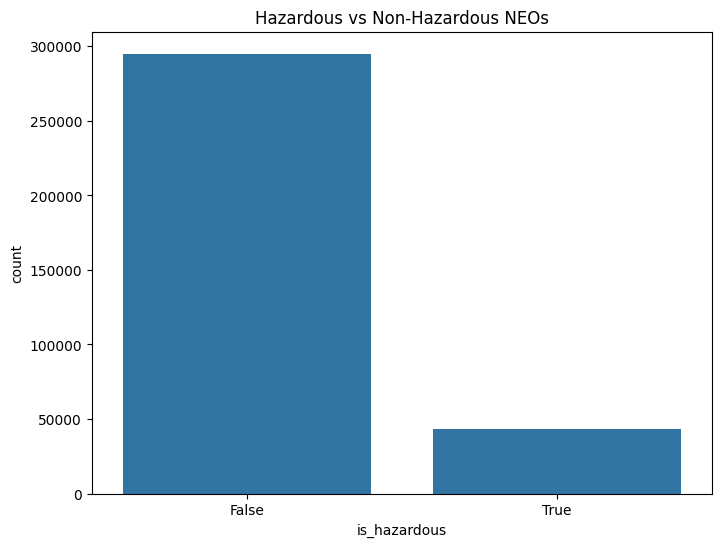

In [59]:
# Count plot of hazardous vs non-hazardous NEOs
neo_pandas = neo.toPandas()

plt.figure(figsize=(8, 6))
sns.countplot(x='is_hazardous', data=neo_pandas)
plt.title('Hazardous vs Non-Hazardous NEOs')
plt.show()

# Standardization of Data

In [39]:
# Import the Required Libraries
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [40]:
# Selecting the columns to be scaled
feature_columns = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']

# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")
assembled_neo = assembler.transform(neo)

# Creating a StandardScaler object
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")

# Fit and transform the data
scaler_model = scaler.fit(assembled_neo)
scaled_neo = scaler_model.transform(assembled_neo)

In [41]:
# Showing Scaled Features
scaled_neo.select("scaled_features").show(10, truncate=False)

+-------------------------------------------------------------------------------------------------+
|scaled_features                                                                                  |
+-------------------------------------------------------------------------------------------------+
|[6.574843570527702,1.2583521713424208,1.2583521709111936,2.717707225791104,2.7988664012644513]   |
|[6.35499509168038,1.6896712022365374,1.6896712038351116,4.16488367158757,2.686101570230607]      |
|[7.368359173867251,0.4343123739409104,0.4343123742057488,0.9419024287873546,3.2351458205109402]  |
|[7.086678310344121,0.6335810831396765,0.6335810843458486,2.988346690547243,1.4631971884028845]   |
|[7.797750734115926,0.24423179454146104,0.24423179533503145,2.1226566674684433,3.0383487121283634]|
|[8.587831204973487,0.08468416360975388,0.08468416383397952,1.7984477070056155,2.0653333168892907]|
|[7.385534836277198,0.42442621787788304,0.4244262171987935,2.191475920511589,1.3131363280159163]  |


# Logistic Regression Algorithm

In [42]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType

# Select relevant columns and cast the label to integer
neo_df = neo.select("name","absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max",
                       "relative_velocity", "miss_distance", "is_hazardous")

# Convert the boolean column 'is_hazardous' to integer
neo_df = neo_df.withColumn("is_hazardous", col("is_hazardous").cast(IntegerType()))

# Define the feature columns
feature_columns = ["absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max",
                   "relative_velocity", "miss_distance"]

# Create a VectorAssembler to combine feature columns into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Create a StandardScaler to scale the feature vector
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

# Create a StringIndexer for the label column
label_indexer = StringIndexer(inputCol="is_hazardous", outputCol="label")

# Create a LogisticRegression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Create a Pipeline with the assembler, scaler, and logistic regression model
lr_pipeline = Pipeline(stages=[assembler, scaler, label_indexer, lr])

# Split the data into training and test sets
train_neo, test_neo = neo_df.randomSplit([0.7, 0.3], seed=42)

# Train the Logistic Regression model
lr_model = lr_pipeline.fit(train_neo)

# Make predictions on the test data
lr_predictions = lr_model.transform(test_neo)

evaluator = MulticlassClassificationEvaluator(labelCol="is_hazardous", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy:.4f}")

# Show predictions
# lr_predictions.select("absolute_magnitude","estimated_diameter_min","estimated_diameter_max","relative_velocity","miss_distance","name", "is_hazardous", "prediction", "probability").show(50)
lr_predictions.show(50)



Test set accuracy = 0.8840
+----------+------------------+----------------------+----------------------+-----------------+-------------+------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|      name|absolute_magnitude|estimated_diameter_min|estimated_diameter_max|relative_velocity|miss_distance|is_hazardous|  assembled_features|            features|label|       rawPrediction|         probability|prediction|
+----------+------------------+----------------------+----------------------+-----------------+-------------+------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| (1982 YA)|             18.01|           0.664591797|           1.486072436|      67940.65328|6.561674916E7|           0|[18.01,0.66459179...|[6.18160863697309...|  0.0|[0.97895551413467...|[0.72690091836042...|       0.0|
| (1982 YA)|             18.01|           0.664591797|           1.486072436|

# ROC Curve

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

Area Under ROC Curve: 0.8424333660711765
Accuracy: 0.8733


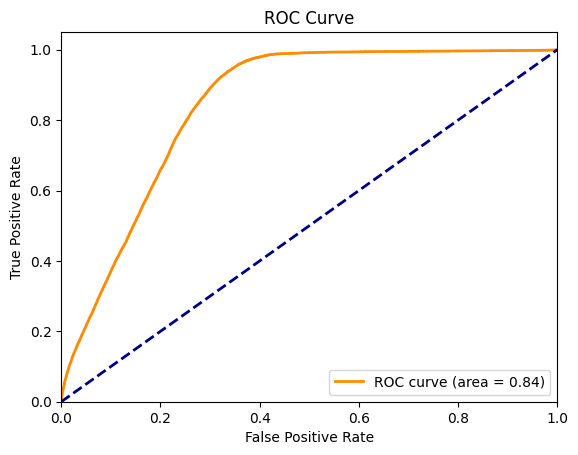

In [44]:
# ROC Curve and AUC Calculation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(lr_predictions)
print(f"Area Under ROC Curve: {roc_auc}")

# Confusion Matrix Calculation
evaluator_cm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_cm.evaluate(lr_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Convert predictions to Pandas DataFrame for plotting ROC Curve
lr_predictions_pd = lr_predictions.select("label", "probability").toPandas()
from sklearn.metrics import roc_curve, auc

y_true = lr_predictions_pd['label']
y_scores = lr_predictions_pd['probability'].apply(lambda x: x[1])

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Decision Tree

In [61]:
# Importing Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [62]:
neo1 = neo.select("absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max",
                       "relative_velocity", "miss_distance","is_hazardous")

# Convert the boolean column 'is_hazardous' to integer
neo1 = neo1.withColumn("is_hazardous", col("is_hazardous").cast(IntegerType()))

feature_columns = [col for col in neo1.columns if col != 'is_hazardous']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(neo1)

# Select only the label and features
data = df_assembled.select('is_hazardous', 'features')

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3])

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(labelCol='is_hazardous', featuresCol='features')

# Train the model
model = dt.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Show the predictions
predictions.show(50)

+------------+--------------------+-----------------+--------------------+----------+
|is_hazardous|            features|    rawPrediction|         probability|prediction|
+------------+--------------------+-----------------+--------------------+----------+
|           0|[10.41,22.0067027...|   [4810.0,380.0]|[0.92678227360308...|       0.0|
|           0|[10.41,22.0067027...|   [4810.0,380.0]|[0.92678227360308...|       0.0|
|           0|[10.41,22.0067027...|[56717.0,21602.0]|[0.72417931791774...|       0.0|
|           0|[12.52,8.32827345...|[56717.0,21602.0]|[0.72417931791774...|       0.0|
|           0|[12.52,8.32827345...|[56717.0,21602.0]|[0.72417931791774...|       0.0|
|           0|[12.84,7.18712133...|  [4795.0,3101.0]|[0.60726950354609...|       0.0|
|           0|[12.84,7.18712133...|[56717.0,21602.0]|[0.72417931791774...|       0.0|
|           0|[13.05,6.52461629...|[56717.0,21602.0]|[0.72417931791774...|       0.0|
|           0|[13.51,5.27904029...|[56717.0,21602.0]|[

In [63]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="is_hazardous", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8837


In [64]:
# Convert predictions to RDD to use MulticlassMetrics
prediction_and_labels = predictions.select(
    col('prediction').cast('double'), col('is_hazardous').cast('double')
).rdd
metrics = MulticlassMetrics(prediction_and_labels)

# Calculate Precision, Recall, and F1 Score
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Get the Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.6761
Recall: 0.1618
F1 Score: 0.2611
Confusion Matrix:
 [[87185.   994.]
 [10748.  2075.]]


In [65]:
# Calculate and print Precision, Recall, and F1 Score for each class
labels = neo.select("is_hazardous").distinct().rdd.flatMap(lambda x: x).collect()
classification_report = []

for label in sorted(labels):
    # Cast the label to a double
    label_double = float(label)

    precision = metrics.precision(label_double)
    recall = metrics.recall(label_double)
    f1_score = metrics.fMeasure(label_double) # Pass label as a double

    # Get the count for the label from the predictionAndLabels RDD
    support = prediction_and_labels.filter(lambda x: x[1] == label_double).count()

    classification_report.append({
        "Class": label, # You can keep the original label type here for display
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Support": support
    })
    print(f"\nClass {label}:\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, Support: {support}")

# Print a formatted classification report
print("\nClassification Report:")
print("Class\tPrecision\tRecall\tF1-Score\tSupport")
for entry in classification_report:
    print(f"{entry['Class']}\t{entry['Precision']:.4f}\t\t{entry['Recall']:.4f}\t{entry['F1-Score']:.4f}\t\t{entry['Support']}")


Class False:
Precision: 0.8903, Recall: 0.9887, F1 Score: 0.9369, Support: 88179

Class True:
Precision: 0.6761, Recall: 0.1618, F1 Score: 0.2611, Support: 12823

Classification Report:
Class	Precision	Recall	F1-Score	Support
False	0.8903		0.9887	0.9369		88179
True	0.6761		0.1618	0.2611		12823


In [66]:
# Print out the tree model
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_6291845c7e80, depth=5, numNodes=17, numClasses=2, numFeatures=5
  If (feature 1 <= 0.10269661499999999)
   Predict: 0.0
  Else (feature 1 > 0.10269661499999999)
   If (feature 4 <= 1.343630635E7)
    If (feature 4 <= 6746471.639)
     Predict: 1.0
    Else (feature 4 > 6746471.639)
     If (feature 4 <= 1.02006822E7)
      Predict: 1.0
     Else (feature 4 > 1.02006822E7)
      If (feature 3 <= 20011.324685)
       Predict: 0.0
      Else (feature 3 > 20011.324685)
       Predict: 1.0
   Else (feature 4 > 1.343630635E7)
    If (feature 3 <= 20011.324685)
     Predict: 0.0
    Else (feature 3 > 20011.324685)
     If (feature 4 <= 2.4975024835E7)
      If (feature 4 <= 1.6471239379999999E7)
       Predict: 1.0
      Else (feature 4 > 1.6471239379999999E7)
       Predict: 0.0
     Else (feature 4 > 2.4975024835E7)
      Predict: 0.0



# Feature Importance

absolute_magnitude: 0.0
estimated_diameter_min: 0.7575574217424692
estimated_diameter_max: 0.0
relative_velocity: 0.03429964597268296
miss_distance: 0.2081429322848478


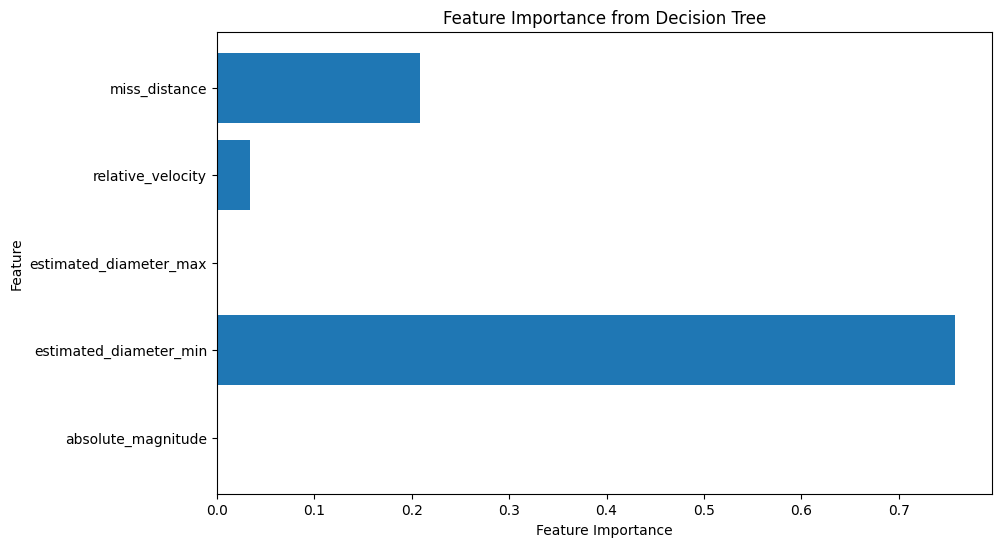

In [67]:
# Get feature importances
importances = model.featureImportances

# Create a list of feature names (assuming you have them available)
feature_names = feature_columns

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Decision Tree")
plt.show()

# Naive Bayes

In [51]:
# Importing Libraries
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

In [52]:
neo1 = neo.select('absolute_magnitude','estimated_diameter_min','estimated_diameter_max','relative_velocity','miss_distance','is_hazardous')

# Convert the boolean column 'is_hazardous' to integer
neo1 = neo1.withColumn("is_hazardous", col("is_hazardous").cast(IntegerType()))

# Assuming 'label' is the column with binary class and the rest are features
feature_columns = neo1.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(neo1)
data = data.select("features", "is_hazardous")

train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

nb = NaiveBayes(featuresCol="features", labelCol="is_hazardous", modelType="multinomial")
model = nb.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="is_hazardous", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy:.4f}")

Test set accuracy = 0.5947


In [53]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'neo1', 'feature_columns', and 'assembler' are already defined as in the Decision Tree code

# Select only the label and features
data = df_assembled.select('is_hazardous', 'features')

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3])

# Create a Naive Bayes model
nb = NaiveBayes(labelCol="is_hazardous", featuresCol="features")

# Train the model
nb_model = nb.fit(train_data)

# Make predictions
predictions = nb_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="is_hazardous", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Show predictions
predictions.select("is_hazardous", "probability", "prediction").show(50)


Accuracy: 0.596309326643212
+------------+--------------------+----------+
|is_hazardous|         probability|prediction|
+------------+--------------------+----------+
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|[1.0,3.4774475910...|       0.0|
|           0|           [0.0,1.0]|       1.0|
|           0|           [0.0,1.0]|       1.0|
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|[1.0,5.4323116932...|       0.0|
|           0|[4.50721162528951...|       1.0|
|           0|           [0.0,1.0]|       1.0|
|           0|           [0.0,1.0]|       1.0|
|           0|[1.0,5.8908130323...|       0.0|
|           0|           [1.0,0.0]|       0.0|
|           0|           [1.0,0.

In [54]:
neo1 = neo.select('absolute_magnitude','estimated_diameter_min','estimated_diameter_max','relative_velocity','miss_distance','is_hazardous')

# Convert the boolean column 'is_hazardous' to integer
neo1 = neo1.withColumn("is_hazardous", col("is_hazardous").cast(IntegerType()))

# Assuming 'label' is the column with binary class and the rest are features
feature_columns = neo1.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(neo1)
data = data.select("features", "is_hazardous")

train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

nb = NaiveBayes(featuresCol="features", labelCol="is_hazardous", modelType="multinomial")
model = nb.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="is_hazardous", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")

Test set accuracy = 0.5946993226254917


# Random Forest Algorithm

In [68]:
from pyspark.ml.classification import RandomForestClassifier

# Select only the label and features
data = df_assembled.select('is_hazardous', 'features')

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3])

# Create a Random Forest model
rf = RandomForestClassifier(labelCol="is_hazardous", featuresCol="features", numTrees=100)

# Train the model
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="is_hazardous", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

# Show predictions
predictions.select("is_hazardous", "probability", "prediction").show(50)

Accuracy: 0.8818
+------------+--------------------+----------+
|is_hazardous|         probability|prediction|
+------------+--------------------+----------+
|           0|[0.73129528355326...|       0.0|
|           0|[0.73026861916653...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0.0|
|           0|[0.73129528355326...|       0

absolute_magnitude: 0.0
estimated_diameter_min: 0.7575574217424692
estimated_diameter_max: 0.0
relative_velocity: 0.03429964597268296
miss_distance: 0.2081429322848478


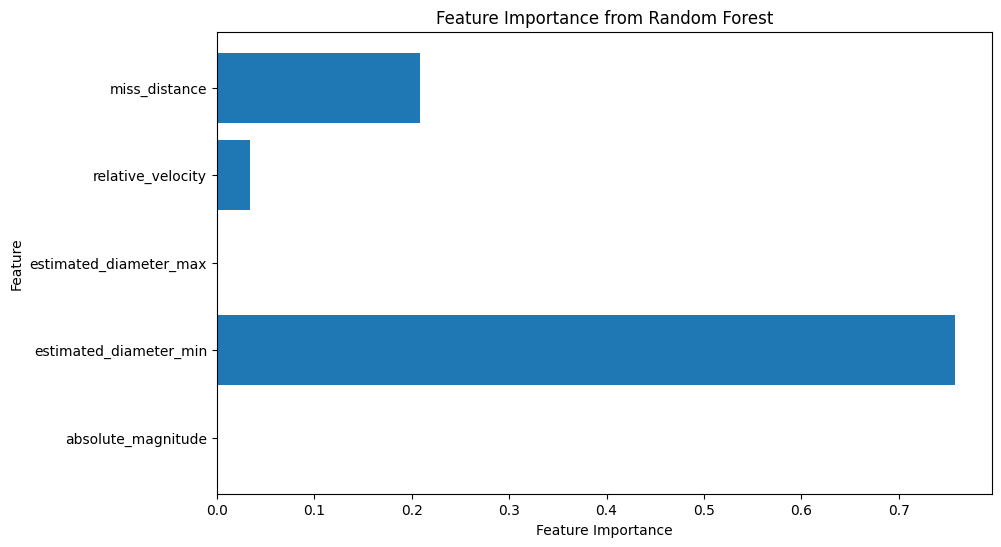

In [70]:
# Get feature importances
importances = model.featureImportances

# Create a list of feature names
feature_names = feature_columns

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.show()